<a href="https://colab.research.google.com/github/linlcc/NLP/blob/master/2_2_SequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

It is a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



## Imports

In [0]:
import matplotlib.pyplot as plt
import math
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work



In [0]:

args=Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "/Users/linlcc/NLP/ps2/ps2-linlcc", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= 4, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/Users/linlcc/NLP/ps2/ps2-linlcc/vectorizer.json
	/Users/linlcc/NLP/ps2/ps2-linlcc/model.pth
Using CUDA: True


### Initializations

In [0]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

### Training loop

In [0]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                          mode='min', factor=0.5,
                                          patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                          batch_size=args.batch_size, 
                                          device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                          batch_size=args.batch_size, 
                                          device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                        train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

In [0]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [0]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))
model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

running_acc = 0.
running_loss = 0.
running_cp =0.
model.eval()

lossc_all=[0]
u=0
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    ppl=math.exp(running_loss)

#-----------------------------------

    for i in range(len(batch_dict['y_target'])):
      a=[]
      for j in range(len(batch_dict['y_target'][i])):
        k=(y_pred[i][j][batch_dict['y_target'][i][j].item()].item())
        a.append(k)
      lossc_all=np.add(lossc_all, a)
    

    # break

    # lossc=[]
    # for i in range(len(y_pred[0])):
    #   # print(y_pred[i])
    #   cp=sequence_loss(y_pred[i], batch_dict['y_target'][i], mask_index)
    #   # print(cp.item())
    #   running_cp += (cp.item()-running_cp)/(i + 1)
      
    #   lossc.append(running_cp)

    # # print(lossc)

    # lossc_all=np.add(lossc_all, lossc)



#-----------------------------------


    

    # compute the accuracy
    u=u+1
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

# print(len(batch_dict['y_target']))
pp=lossc_all/u/ (len(batch_dict['y_target']))
# print(pp)
p=[math.exp(y) for y in pp]
# print(p)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

Compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

Test loss: 2.9508730371793113;
Test perplexity: 19.122641219522833;
Test Accuracy: 17.354775861180666

Average Perplexity for each character position
Position 1: 29.39
Position 2: 17.51
Position 3: 11.07
Position 4: 12.21
Position 5: 12.53
Position 6: 8.92
Position 7: 4.31
Position 8: 1.45
Position 9: 0.51
Position 10: 0.26
Position 11: 0.16
Position 12: 0.11
Position 13: 0.11
Position 14: 0.10
Position 15: 0.10
Position 16: 0.10
Position 17: 0.10
Position 18: 0.10
Position 19: 0.10


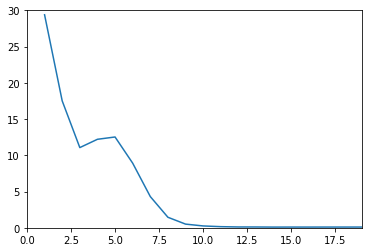

In [0]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(ppl)) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))
print("")
print("Average Perplexity for each character position")
for i in range (len(p)):
  print("Position %d: %.2f" % (i+1, p[i]))

x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
plt.plot(x,p)
plt.axis([0, 19, 0, 30])
plt.show()


## Inference
To see the names that the model generates:

In [0]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Nidnsib
Albsnmenacd
SioanyomnÉmys
Kmehanaelo
Tersdkoeu
Ata
Muieiifek
Vlnidnurer
Spinmdkyy
Sanarrveemtlsdwolo


Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. 

In [0]:
def all_code(rnn):
    args=Namespace(
        # Data and Path information
        surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
        vectorizer_file="vectorizer.json",
        model_state_file="model.pth",
        save_dir= "/Users/linlcc/NLP/ps2/ps2-linlcc", # give path here
        # Model hyper parameters
        char_embedding_size=32,
        rnn_hidden_size= rnn, # give hidden size
        # Training hyper parameters
        seed=1337,
        learning_rate=0.001,
        batch_size=128,
        num_epochs=100,
        early_stopping_criteria=5,
        # Runtime options
        catch_keyboard_interrupt=True,
        cuda=True,
        expand_filepaths_to_save_dir=True,
        reload_from_files=False,
    )


    if args.expand_filepaths_to_save_dir:
        args.vectorizer_file = os.path.join(args.save_dir,
                                            args.vectorizer_file)

        args.model_state_file = os.path.join(args.save_dir,
                                            args.model_state_file)
        
        print("Expanded filepaths: ")
        print("\t{}".format(args.vectorizer_file))
        print("\t{}".format(args.model_state_file))
        
        
    # Check CUDA
    if not torch.cuda.is_available():
        args.cuda = False

    args.device = torch.device("cuda" if args.cuda else "cpu")
        
    print("Using CUDA: {}".format(args.cuda))

    # Set seed for reproducibility
    set_seed_everywhere(args.seed, args.cuda)

    # handle dirs
    handle_dirs(args.save_dir)

    if args.reload_from_files:
        # training from a checkpoint
        dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                                  args.vectorizer_file)
    else:
        # create dataset and vectorizer
        dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
        dataset.save_vectorizer(args.vectorizer_file)

    vectorizer = dataset.get_vectorizer()

    model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                                  char_vocab_size=len(vectorizer.char_vocab),
                                  rnn_hidden_size=args.rnn_hidden_size,
                                  padding_idx=vectorizer.char_vocab.mask_index)
    mask_index = vectorizer.char_vocab.mask_index

    model = model.to(args.device)


    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                              mode='min', factor=0.5,
                                              patience=1)
    train_state = make_train_state(args)

    epoch_bar = tqdm_notebook(desc='training routine', 
                              total=args.num_epochs,
                              position=0)

    dataset.set_split('train')
    train_bar = tqdm_notebook(desc='split=train',
                              total=dataset.get_num_batches(args.batch_size), 
                              position=1, 
                              leave=True)
    dataset.set_split('val')
    val_bar = tqdm_notebook(desc='split=val',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                              batch_size=args.batch_size, 
                                              device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            model.train()
            
            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------    
                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. compute the output
                y_pred = model(x_in=batch_dict['x_data'])

                # step 3. compute the loss
                loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the  running loss and running accuracy
                running_loss += (loss.item() - running_loss) / (batch_index + 1)
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss,
                                      acc=running_acc,
                                      epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                              batch_size=args.batch_size, 
                                              device=args.device)
            running_loss = 0.
            running_acc = 0.
            model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):
                # compute the output
                y_pred = model(x_in=batch_dict['x_data'])

                # step 3. compute the loss
                loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

                # compute the  running loss and running accuracy
                running_loss += (loss.item() - running_loss) / (batch_index + 1)
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                
                # Update bar
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=model, 
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break
            
            # move model to cpu for sampling
            model = model.cpu()
            sampled_surnames = decode_samples(
                sample_from_model(model, vectorizer, num_samples=2), 
                vectorizer)
            epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                                  sample2=sampled_surnames[1])
            # move model back to whichever device it should be on
            model = model.to(args.device)
            
            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
            
    except KeyboardInterrupt:
        print("Exiting loop")


    np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

    # compute the loss & accuracy on the test set using the best available model

    model.load_state_dict(torch.load(train_state['model_filename']))
    model = model.to(args.device)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                      batch_size=args.batch_size, 
                                      device=args.device)

    running_acc = 0.
    running_loss = 0.
    running_cp =0.
    model.eval()

    lossc_all=[0]
    u=0
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = model(x_in=batch_dict['x_data'])

        # compute the loss
        loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        ppl=math.exp(running_loss)

    #-----------------------------------

        for i in range(len(batch_dict['y_target'])):
          a=[]
          for j in range(len(batch_dict['y_target'][i])):
            k=(y_pred[i][j][batch_dict['y_target'][i][j].item()].item())
            a.append(k)
          lossc_all=np.add(lossc_all, a)
        

        # break

        # lossc=[]
        # for i in range(len(y_pred[0])):
        #   # print(y_pred[i])
        #   cp=sequence_loss(y_pred[i], batch_dict['y_target'][i], mask_index)
        #   # print(cp.item())
        #   running_cp += (cp.item()-running_cp)/(i + 1)
          
        #   lossc.append(running_cp)

        # # print(lossc)

        # lossc_all=np.add(lossc_all, lossc)



    #-----------------------------------


        

        # compute the accuracy
        u=u+1
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    # print(len(batch_dict['y_target']))
    pp=lossc_all/u/ (len(batch_dict['y_target']))
    # print(pp)
    p=[math.exp(y) for y in pp]
    # print(p)

    train_state['test_loss'] = running_loss 
    train_state['test_acc'] = running_acc 


    # print("Test loss: {};".format(train_state['test_loss']))
    # print("Test perplexity: {};".format(ppl)) # compute and print perplexity here
    # print("Test Accuracy: {}".format(train_state['test_acc']))
    # print("")
    # print("Average Perplexity for each character position")
    # for i in range (len(p)):
    #   print("Position %d: %.2f" % (i+1, p[i]))

    # x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    # plt.plot(x,p)
    # plt.axis([0, 19, 0, 30])
    # plt.show()


    return p



In [0]:
rnn=[1,2,4,8,16]

ppl_char=[]
for i in range(len(rnn)):
  ppl_char.append(all_code(rnn[i]))


Expanded filepaths: 
	/Users/linlcc/NLP/ps2/ps2-linlcc/vectorizer.json
	/Users/linlcc/NLP/ps2/ps2-linlcc/model.pth
Using CUDA: True


Expanded filepaths: 
	/Users/linlcc/NLP/ps2/ps2-linlcc/vectorizer.json
	/Users/linlcc/NLP/ps2/ps2-linlcc/model.pth
Using CUDA: True


Expanded filepaths: 
	/Users/linlcc/NLP/ps2/ps2-linlcc/vectorizer.json
	/Users/linlcc/NLP/ps2/ps2-linlcc/model.pth
Using CUDA: True


Expanded filepaths: 
	/Users/linlcc/NLP/ps2/ps2-linlcc/vectorizer.json
	/Users/linlcc/NLP/ps2/ps2-linlcc/model.pth
Using CUDA: True


Expanded filepaths: 
	/Users/linlcc/NLP/ps2/ps2-linlcc/vectorizer.json
	/Users/linlcc/NLP/ps2/ps2-linlcc/model.pth
Using CUDA: True


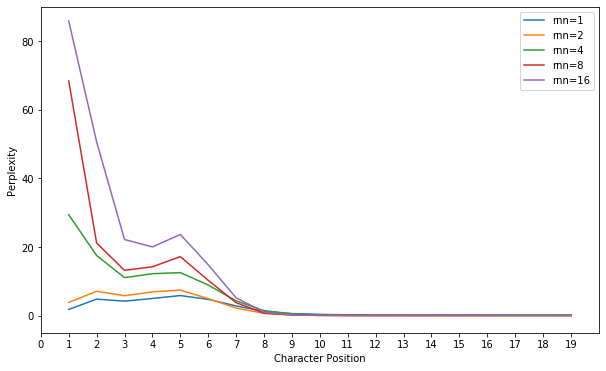

In [0]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
plt.figure(figsize=(10,6))
plt.plot(x, ppl_char[0], label='rnn=1')
plt.plot(x, ppl_char[1], label='rnn=2')
plt.plot(x, ppl_char[2], label='rnn=4')
plt.plot(x, ppl_char[3], label='rnn=8')
plt.plot(x, ppl_char[4], label='rnn=16')
plt.axis([0, 20, -5, 90])
plt.xlabel('Character Position')
plt.ylabel('Perplexity')
plt.legend()
plt.xticks(range(0, 20))
plt.show()


From the plot above, we can see that with 
more rnn_hidden_size, the higher perplexity happened at the beginging of characters. It might due to our training set is not big enough, with more hidden layer, the errors might be calculated more times than just one or two layers which cuases perplexity higher. Also, we can see at position 4 and 5, the perplexity is increasing and then decreasing again at position 6. This might because of more characters can be put in the 4th and 5th position in names.  with more characters can be put in, the more perplexity would occur on these positions. After position 9, we can see less perplexity shown on plot. This might becuase of less names are longer than 9 characters in training set as well as test set, we can not get good model from these data. Therefore, either just few characters can put in(not enough data to train, less perplexity) or test set is too small to show the real perplexity.